In [1]:
import sys

sys.path.append("..")
import pickle as pkl
from copy import deepcopy
from dataclasses import asdict, is_dataclass
from itertools import product

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from dacite import from_dict
from ipywidgets import interact
from scipy.spatial.transform import Rotation
from tqdm.auto import tqdm

from calibration.benchmark.benchmark import BenchmarkResult, benchmark_simul
from calibration.feature_detector.visualization import show_boards, show_corners
from calibration.projector.board import gen_charuco_grid, gen_checkerboard_grid
from calibration.projector.camera import Camera

# pio.renderers.default = "svg"
from calibration.projector.projector import Projector
from calibration.solver.solve import solve

%load_ext autoreload
%autoreload 2

In [2]:
with open("../simul_results.pkl", "rb") as f:
    results = pkl.load(f)

In [33]:
df = pd.json_normalize([asdict(o) for o in results])

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   error                           100000 non-null  float64
 1   input.R                         100000 non-null  object 
 2   input.t                         100000 non-null  object 
 3   input.lambdas                   100000 non-null  object 
 4   input.camera.focal_length       100000 non-null  float64
 5   input.camera.sensor_size        100000 non-null  object 
 6   input.camera.resolution         100000 non-null  object 
 7   input.camera.skew               100000 non-null  float64
 8   features.board                  100000 non-null  object 
 9   features.corners                100000 non-null  object 
 10  prediction.R                    100000 non-null  object 
 11  prediction.t                    100000 non-null  object 
 12  prediction.lambda

In [35]:
for i in range(3):
    for j in range(3):
        df[f"R{i}{j}"] = [R[i][j] for R in df["input.R"]]
    df[f"t{i}"] = [t[i] for t in df["input.t"]]

for i in range(2):
    df[f"lambda{i}"] = [t[i] for t in df["input.lambdas"]]

In [36]:
df = df.drop(columns=["input.R", "input.t", "input.lambdas"])

In [37]:
cols = df.columns
cols

Index(['error', 'input.camera.focal_length', 'input.camera.sensor_size',
       'input.camera.resolution', 'input.camera.skew', 'features.board',
       'features.corners', 'prediction.R', 'prediction.t',
       'prediction.lambdas', 'prediction.camera.focal_length',
       'prediction.camera.sensor_size', 'prediction.camera.resolution',
       'prediction.camera.skew', 'R00', 'R01', 'R02', 't0', 'R10', 'R11',
       'R12', 't1', 'R20', 'R21', 'R22', 't2', 'lambda0', 'lambda1'],
      dtype='object')

In [38]:
cols = [
    c
    for c in cols
    if "input" not in c and "prediction" not in c and "features" not in c
]

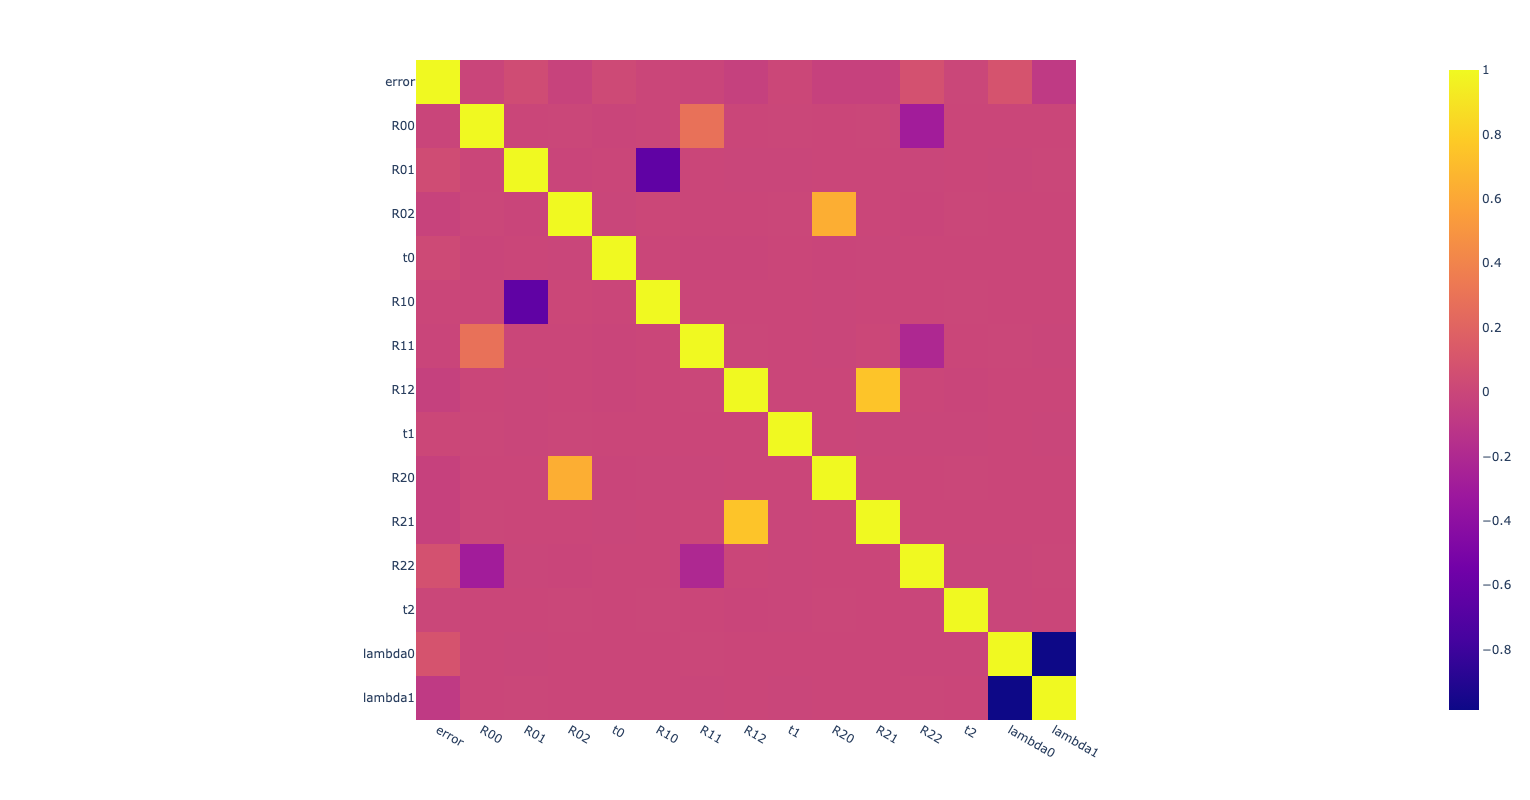

In [39]:
px.imshow(df[cols].corr(), height=800)

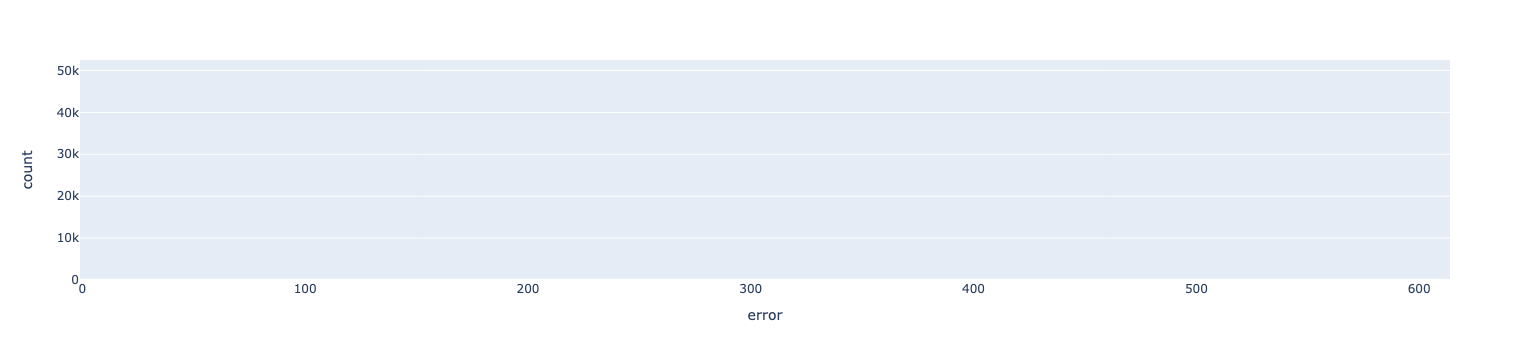

In [40]:
px.histogram(df, x='error')

In [41]:
df['error'].value_counts()

error
-1.000000e+00    44294
 1.012803e-13        3
 7.566424e-14        3
 9.581565e-14        3
 7.201769e-14        3
                 ...  
 2.091991e-11        1
 8.084227e-11        1
 5.492072e-11        1
 3.568522e-12        1
 3.007274e-11        1
Name: count, Length: 55653, dtype: int64